# Introduction

In this notebook, we present how different values of the post-processing threshold affects the results of the model. In this notebook, let $t \in [0, 1]$ be the threshold value.

As a reminder, during the post-processing step, we select segments that exhibit a high degree of non-compliance with the connectivity table. A segment is flagged for correction if at least a $t$ proportion of its border pixels are adjacent to neighboring segments that are classified into disallowed classes according to the connectivity table. For these selected segments, we examine the neighboring segments; if all neighboring segments belong to the same permissible class, we reassign the segment to this class, thereby aligning the segment with its spatial context and expected adjacency.

The tests are made on the 10 m resolution image. 

# Loading the packages and data

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import pandas as pd
import importlib
import matplotlib.pyplot as plt
import itertools
import random
import time

In [3]:
from coral_mapper_functions import score_map
from coral_mapper import coral_map

## Loading the connectivity table

In [4]:
connectivity = pd.read_pickle('connectivity_table_maupiti')

In [5]:
connectivity

,5,9,8,6,2,1,10,3,7,11,4
Unnamed: 0,,,,,,,,,,,
5,NaN,0.0,0.0,2.0,1.0,1.0,1.0,2.0,1.0,1.0,1.0
9,0.0,NaN,0.0,2.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
8,0.0,0.0,NaN,0.0,2.0,1.0,1.0,1.0,1.0,1.0,1.0
6,2.0,2.0,0.0,NaN,0.0,2.0,1.0,1.0,1.0,1.0,1.0
2,1.0,1.0,2.0,0.0,NaN,0.0,2.0,1.0,1.0,1.0,2.0
1,1.0,1.0,1.0,2.0,0.0,NaN,1.0,2.0,1.0,1.0,2.0
10,1.0,1.0,1.0,1.0,2.0,1.0,NaN,0.0,0.0,0.0,2.0
3,2.0,1.0,1.0,1.0,1.0,2.0,0.0,NaN,0.0,0.0,2.0
7,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,NaN,0.0,2.0


## Loading the data

In [7]:
img_rugo_zones = np.load('../v2/data/pleiades_map_types_10m.npy')
pleiades_img = np.load('../v2/data/pleiades_ortho_10m.npy')

In [8]:
img_blue = (pleiades_img[1]-np.mean(pleiades_img[1]))/np.std(pleiades_img[1])
img_green = (pleiades_img[2]-np.mean(pleiades_img[2]))/np.std(pleiades_img[2])
img_red = (pleiades_img[3]-np.mean(pleiades_img[3]))/np.std(pleiades_img[3])
img_nir = (pleiades_img[0]-np.mean(pleiades_img[0]))/np.std(pleiades_img[0])

# Trying different values of $t$

We repeat 10 times:
- Train the model once.
- Make a prediction on the test set.
- On this prediction, perform a post-processing with different values of $t$ (from 0.1 to 1. with a step of 0.05)

In [9]:
classified_pixels = np.where(img_rugo_zones>0)
size_subset = 250000
index_combination = list(np.array(classified_pixels).T)

In [20]:
%%time
scores_repetition = []
for seed in range(10):
    
    # train the model
    map_test = coral_map([img_blue,img_green,img_red,img_nir], map_img=img_rugo_zones, size_img=3)
    random.seed(seed*10)
    
    random_train_test = random.sample(index_combination,size_subset)
    training_set_indexes_pb = random_train_test[:size_subset//5]
    testing_set_indexes_pb = random_train_test[size_subset//5:]

    map_test.train_pixelbased_rf(training_set_indexes_pb, testing_set_indexes_pb, undersampling=0)

    map_test.predict_map_pixelbased_rf()

    predicted_map_pixelbased_rf_classes = np.argmax(map_test.predicted_map_pb_rf,axis=2)+1
    
    #smoothing
    map_test.segmentation(use_pb_pred=True, scale=1.5, sigma=1., min_size=20)
    map_test.smooth_pb_rf()
    map_test.smoothed_map_pb_rf = map_test.smoothed_map_pb_rf+1
    smooth_map = np.copy(map_test.smoothed_map_pb_rf)
    
    scores_pp = []
    #post-processing
    for t in np.arange(0.1,1.05,0.05):
        map_test.post_processing(connectivity, threshold_w=t, threshold_a=1.1)
        score_pp = score_map(img_rugo_zones, map_test.post_processed_map, [0,4,5], map_test.segments, training_set_indexes_pb, [], size_superpixel=3)
        scores_pp.append(score_pp)
        
    scores_repetition.append(scores_pp)

C:\Users\tnguyen001\Documents\GitHub\coral_mapping\clean\coral_mapper.py:142: UserWarning: The training set does not contain all the classes. Errors may occur.
  warnings.warn("The training set does not contain all the classes. Errors may occur.")


Creating the labels for each superpixel...
Creating the features for each superpixel...
Training the Random Forest classifier...
Validation accuracy: 0.970405


C:\Users\tnguyen001\Documents\GitHub\coral_mapping\clean\coral_mapper.py:92: RuntimeWarning: Got image with third dimension of 4. This image will be interpreted as a multichannel 2d image, which may not be intended.
  segments = felzenszwalb(img_for_segmentation,*args,**kwargs)
C:\Users\tnguyen001\Documents\GitHub\coral_mapping\clean\coral_mapper.py:142: UserWarning: The training set does not contain all the classes. Errors may occur.
  warnings.warn("The training set does not contain all the classes. Errors may occur.")


Creating the labels for each superpixel...
Creating the features for each superpixel...
Training the Random Forest classifier...
Validation accuracy: 0.96992


C:\Users\tnguyen001\Documents\GitHub\coral_mapping\clean\coral_mapper.py:92: RuntimeWarning: Got image with third dimension of 4. This image will be interpreted as a multichannel 2d image, which may not be intended.
  segments = felzenszwalb(img_for_segmentation,*args,**kwargs)
C:\Users\tnguyen001\Documents\GitHub\coral_mapping\clean\coral_mapper.py:142: UserWarning: The training set does not contain all the classes. Errors may occur.
  warnings.warn("The training set does not contain all the classes. Errors may occur.")


Creating the labels for each superpixel...
Creating the features for each superpixel...
Training the Random Forest classifier...
Validation accuracy: 0.97107


C:\Users\tnguyen001\Documents\GitHub\coral_mapping\clean\coral_mapper.py:92: RuntimeWarning: Got image with third dimension of 4. This image will be interpreted as a multichannel 2d image, which may not be intended.
  segments = felzenszwalb(img_for_segmentation,*args,**kwargs)
C:\Users\tnguyen001\Documents\GitHub\coral_mapping\clean\coral_mapper.py:142: UserWarning: The training set does not contain all the classes. Errors may occur.
  warnings.warn("The training set does not contain all the classes. Errors may occur.")


Creating the labels for each superpixel...
Creating the features for each superpixel...
Training the Random Forest classifier...
Validation accuracy: 0.969975


C:\Users\tnguyen001\Documents\GitHub\coral_mapping\clean\coral_mapper.py:92: RuntimeWarning: Got image with third dimension of 4. This image will be interpreted as a multichannel 2d image, which may not be intended.
  segments = felzenszwalb(img_for_segmentation,*args,**kwargs)
C:\Users\tnguyen001\Documents\GitHub\coral_mapping\clean\coral_mapper.py:142: UserWarning: The training set does not contain all the classes. Errors may occur.
  warnings.warn("The training set does not contain all the classes. Errors may occur.")


Creating the labels for each superpixel...
Creating the features for each superpixel...
Training the Random Forest classifier...
Validation accuracy: 0.970745


C:\Users\tnguyen001\Documents\GitHub\coral_mapping\clean\coral_mapper.py:92: RuntimeWarning: Got image with third dimension of 4. This image will be interpreted as a multichannel 2d image, which may not be intended.
  segments = felzenszwalb(img_for_segmentation,*args,**kwargs)
C:\Users\tnguyen001\Documents\GitHub\coral_mapping\clean\coral_mapper.py:142: UserWarning: The training set does not contain all the classes. Errors may occur.
  warnings.warn("The training set does not contain all the classes. Errors may occur.")


Creating the labels for each superpixel...
Creating the features for each superpixel...
Training the Random Forest classifier...
Validation accuracy: 0.970385


C:\Users\tnguyen001\Documents\GitHub\coral_mapping\clean\coral_mapper.py:92: RuntimeWarning: Got image with third dimension of 4. This image will be interpreted as a multichannel 2d image, which may not be intended.
  segments = felzenszwalb(img_for_segmentation,*args,**kwargs)
C:\Users\tnguyen001\Documents\GitHub\coral_mapping\clean\coral_mapper.py:142: UserWarning: The training set does not contain all the classes. Errors may occur.
  warnings.warn("The training set does not contain all the classes. Errors may occur.")


Creating the labels for each superpixel...
Creating the features for each superpixel...
Training the Random Forest classifier...
Validation accuracy: 0.970875


C:\Users\tnguyen001\Documents\GitHub\coral_mapping\clean\coral_mapper.py:92: RuntimeWarning: Got image with third dimension of 4. This image will be interpreted as a multichannel 2d image, which may not be intended.
  segments = felzenszwalb(img_for_segmentation,*args,**kwargs)
C:\Users\tnguyen001\Documents\GitHub\coral_mapping\clean\coral_mapper.py:142: UserWarning: The training set does not contain all the classes. Errors may occur.
  warnings.warn("The training set does not contain all the classes. Errors may occur.")


Creating the labels for each superpixel...
Creating the features for each superpixel...
Training the Random Forest classifier...
Validation accuracy: 0.970265


C:\Users\tnguyen001\Documents\GitHub\coral_mapping\clean\coral_mapper.py:92: RuntimeWarning: Got image with third dimension of 4. This image will be interpreted as a multichannel 2d image, which may not be intended.
  segments = felzenszwalb(img_for_segmentation,*args,**kwargs)
C:\Users\tnguyen001\Documents\GitHub\coral_mapping\clean\coral_mapper.py:142: UserWarning: The training set does not contain all the classes. Errors may occur.
  warnings.warn("The training set does not contain all the classes. Errors may occur.")


Creating the labels for each superpixel...
Creating the features for each superpixel...
Training the Random Forest classifier...
Validation accuracy: 0.97026


C:\Users\tnguyen001\Documents\GitHub\coral_mapping\clean\coral_mapper.py:92: RuntimeWarning: Got image with third dimension of 4. This image will be interpreted as a multichannel 2d image, which may not be intended.
  segments = felzenszwalb(img_for_segmentation,*args,**kwargs)
C:\Users\tnguyen001\Documents\GitHub\coral_mapping\clean\coral_mapper.py:142: UserWarning: The training set does not contain all the classes. Errors may occur.
  warnings.warn("The training set does not contain all the classes. Errors may occur.")


Creating the labels for each superpixel...
Creating the features for each superpixel...
Training the Random Forest classifier...
Validation accuracy: 0.97082


C:\Users\tnguyen001\Documents\GitHub\coral_mapping\clean\coral_mapper.py:92: RuntimeWarning: Got image with third dimension of 4. This image will be interpreted as a multichannel 2d image, which may not be intended.
  segments = felzenszwalb(img_for_segmentation,*args,**kwargs)


Wall time: 41min 23s


# Display the results

In [35]:
scores_repetition

[[0.8466930036956799,
  0.8466930036956799,
  0.8477125015929655,
  0.8508347139034026,
  0.8532560214094559,
  0.8535108958837773,
  0.8553587358226074,
  0.856569389575634,
  0.8608385370205174,
  0.8610296928762584,
  0.8627500955779279,
  0.860774818401937,
  0.8609022556390977,
  0.8603287880718746,
  0.8614120045877406,
  0.8614120045877406,
  0.8614757232063209,
  0.8614757232063209,
  0.8616031604434816],
 [0.835615581817045,
  0.8354279997498906,
  0.8359907459513537,
  0.8408053523416494,
  0.8418057900331395,
  0.8421184268117301,
  0.8461201775776902,
  0.8471831426248984,
  0.8494966547864691,
  0.8504970924779591,
  0.8518101669480398,
  0.8518101669480398,
  0.8537485149753017,
  0.8537485149753017,
  0.8537485149753017,
  0.8537485149753017,
  0.8528106046395298,
  0.8527480772838116,
  0.852873131995248],
 [0.836963610277814,
  0.836963610277814,
  0.8392461197339246,
  0.8417894874135907,
  0.8421807747489239,
  0.8432894221990348,
  0.8432894221990348,
  0.8446589278

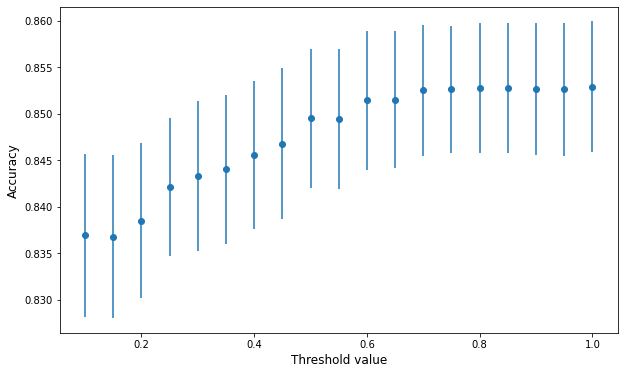

In [36]:
plt.figure(figsize=(10,6))
plt.errorbar(np.arange(0.1,1.05,0.05), 
             np.mean(scores_repetition,axis=0), 
             np.std(scores_repetition,axis=0),
             linestyle='None', marker='o')
plt.xlabel('Threshold value', size=12)
plt.ylabel('Accuracy', size=12)
plt.savefig('threshold_values_10m.png', dpi=100)
plt.show()